Данные взял изначальные без предобработки, т.к. на них скор получается лучше. Видимо из-за того, что во время предобработки теряется много данных.

Так же тут отражен только последний шаг, который привел к лучшему скору. До этого были различные попытки обработки данных.

In [1]:
# библиотеки, ворнинги
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
import shap
from phik.report import plot_correlation_matrix


import warnings
warnings.filterwarnings('ignore')

In [2]:
# стили
plt.style.use('dark_background')
pd.set_option('display.max_columns', None)

In [3]:
# данные
test_for_sub = pd.read_csv('C:/Users/Vladimir/Desktop/cSV/leopard challendge/test.csv')
df = pd.read_csv('C:/Users\Vladimir/Desktop/cSV/leopard challendge/train.csv')

In [4]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id'],
      dtype='object')

In [5]:
test_for_sub.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG', 'Date',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude',
       'Regionname', 'Propertycount', 'id'],
      dtype='object')

In [6]:
df.corr().style.background_gradient(cmap='RdYlGn')

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,id
Rooms,1.000000,0.499639,0.289296,0.063347,0.948558,0.597412,0.412486,0.026276,0.126645,-0.056456,0.021266,0.092957,-0.091478,0.004325
Price,0.499639,1.000000,-0.172521,0.097487,0.477260,0.463648,0.238572,0.037681,0.094909,-0.326959,-0.206103,0.198808,-0.053093,-0.004071
Distance,0.289296,-0.172521,1.000000,0.445167,0.297242,0.134004,0.261796,0.025639,0.094182,0.250387,-0.134965,0.235059,-0.062055,0.009637
Postcode,0.063347,0.097487,0.445167,1.000000,0.065251,0.116897,0.057261,0.025634,0.051450,0.045513,-0.384734,0.433615,0.043574,-0.002026
Bedroom2,0.948558,0.477260,0.297242,0.065251,1.000000,0.589781,0.409478,0.026252,0.124850,-0.044475,0.019054,0.096736,-0.081073,0.003916
Bathroom,0.597412,0.463648,0.134004,0.116897,0.589781,1.000000,0.324802,0.037824,0.114884,0.161851,-0.064928,0.118039,-0.051356,0.002075
Car,0.412486,0.238572,0.261796,0.057261,0.409478,0.324802,1.000000,0.026891,0.096393,0.109409,-0.004129,0.063781,-0.023414,0.015916
Landsize,0.026276,0.037681,0.025639,0.025634,0.026252,0.037824,0.026891,1.000000,0.500572,0.037400,0.009538,0.011460,-0.007011,0.003446
BuildingArea,0.126645,0.094909,0.094182,0.051450,0.124850,0.114884,0.096393,0.500572,1.000000,0.026426,0.040215,-0.021007,-0.027900,-0.003004
YearBuilt,-0.056456,-0.326959,0.250387,0.045513,-0.044475,0.161851,0.109409,0.037400,0.026426,1.000000,0.063608,-0.002722,0.007249,0.019772


Очень сильно коррелирует price с Bedroom2. Не буду использовать Bedroom2.

In [7]:
# возьмём небольшую часть данных, чтобы оценить влияние по Фику
df_exp = df.sample(frac=0.05, random_state=42)
phik_overview = df_exp.phik_matrix()

interval columns not set, guessing: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'id']


In [8]:
# смотрим зависимоть по Фику
phik_overview['Price'].sort_values(ascending=False)

Address          1.000000
Price            1.000000
BuildingArea     0.696160
CouncilArea      0.508622
Type             0.488028
Bathroom         0.464978
YearBuilt        0.415987
Suburb           0.415610
Rooms            0.404530
Bedroom2         0.375137
Regionname       0.326648
SellerG          0.319844
Method           0.284778
Car              0.280614
Lattitude        0.274031
Postcode         0.271711
Propertycount    0.266345
Longtitude       0.232429
id               0.077716
Distance         0.000000
Date             0.000000
Landsize         0.000000
Name: Price, dtype: float64

In [9]:
# посмотрю пропуски в наиболее влиятельных по мнению фика фичах
df[['Address', 'BuildingArea', 'CouncilArea']].isna().sum()

Address             0
BuildingArea    10623
CouncilArea         1
dtype: int64

In [10]:
# предобработаю CouncilArea
df[df['CouncilArea'].isna()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
14406,Footscray,2/16 Stafford St,2,u,710000.0,S,Jas,15/07/2017,5.1,3011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21235


In [11]:
df[df['Suburb'] == 'Footscray'].sample(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
15543,Footscray,69 Creswick St,2,h,978000.0,SP,Jas,3/09/2017,5.1,3011.0,2.0,1.0,1.0,NaN,111.0,1900.0,Maribyrnong City Council,-37.79617,144.89116,Western Metropolitan,7570.0,13528
3442,Footscray,12/14 Eldridge St,2,u,315000.0,PI,C21,25/02/2017,6.4,3011.0,2.0,1.0,1.0,882.0,74.0,1970.0,Maribyrnong City Council,-37.78990,144.89300,Western Metropolitan,7570.0,342
3425,Footscray,88 Victoria St,3,h,875000.0,S,Village,18/03/2017,6.4,3011.0,3.0,1.0,0.0,262.0,92.0,NaN,Maribyrnong City Council,-37.80220,144.89240,Western Metropolitan,7570.0,9337
3465,Footscray,20 Nicholson St,4,h,1450000.0,SP,Village,28/08/2016,6.4,3011.0,4.0,1.0,1.0,799.0,160.0,1910.0,Maribyrnong City Council,-37.79580,144.90010,Western Metropolitan,7570.0,1219
3368,Footscray,4/33 Ballarat Rd,3,t,585000.0,S,Nelson,3/09/2016,6.4,3011.0,3.0,1.0,1.0,259.0,NaN,NaN,Maribyrnong City Council,-37.79550,144.90630,Western Metropolitan,7570.0,62


In [12]:
t = df[df['Suburb'] == 'Footscray'][['CouncilArea', 'Regionname', 'Propertycount']]

for i in t.columns:
    print(t[i].unique())

['Maribyrnong City Council' nan]
['Western Metropolitan' nan]
[7570.   nan]


Получается у 1 объекта пропущено значение округа. Т.к. это территория, проверил, что у всех объектов совпадают территориальные поля.Заполню их. 

In [13]:
df['CouncilArea'] = df['CouncilArea'].fillna('Maribyrnong City Council')
df['Regionname'] = df['Regionname'].fillna('Western Metropolitan')
df['Propertycount'] = df['Propertycount'].fillna(7570.0)

In [14]:
# дам медианное значение пропускам по площади объекта
df['BuildingArea'] = df['BuildingArea'].fillna(np.median(df['BuildingArea']))

In [15]:
X = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname']
y = ['Price']
cat_features = ['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']

In [16]:
# разобью тренировочную выборку на тренировочную и тестовую
train, test = train_test_split(df, random_state = 42, train_size = 0.6)

In [17]:
# из тестовой выделю данные для валидации
train_val, test = train_test_split(test, random_state=42, train_size=0.5)

In [18]:
# провею
print(round(len(train) / len(df), 1)) 
print(round(len(train_val) / len(df), 1)) 
print(round(len(test) / len(df), 1)) 

0.6
0.2
0.2


In [19]:
# параметры модели
parametrs = {'cat_features': cat_features, 
             'eval_metric': 'MAPE', 
             'verbose': 100, #показывать каждую 100-ю строчку
             'random_seed': 42,
             'learning_rate': 0.11, #скорость обучения модели
             'early_stopping_rounds': 200}

In [20]:
model = CatBoostRegressor(**parametrs)

In [21]:
# обучаю модель. 
model.fit(train[X], train[y], eval_set=(train_val[X], train_val[y]))

0:	learn: 0.4982674	test: 0.4876867	best: 0.4876867 (0)	total: 216ms	remaining: 3m 36s
100:	learn: 0.1716164	test: 0.1695677	best: 0.1695677 (100)	total: 5.23s	remaining: 46.6s
200:	learn: 0.1558239	test: 0.1599085	best: 0.1599085 (200)	total: 10.1s	remaining: 40.3s
300:	learn: 0.1467033	test: 0.1552202	best: 0.1552202 (300)	total: 14.6s	remaining: 33.9s
400:	learn: 0.1411695	test: 0.1537035	best: 0.1537035 (400)	total: 19.6s	remaining: 29.3s
500:	learn: 0.1363037	test: 0.1525249	best: 0.1524627 (490)	total: 24.5s	remaining: 24.4s
600:	learn: 0.1323447	test: 0.1515803	best: 0.1515138 (583)	total: 29.3s	remaining: 19.5s
700:	learn: 0.1288339	test: 0.1509870	best: 0.1509661 (699)	total: 34.3s	remaining: 14.6s
800:	learn: 0.1252160	test: 0.1498539	best: 0.1498041 (794)	total: 38.9s	remaining: 9.65s
900:	learn: 0.1222127	test: 0.1498710	best: 0.1496270 (846)	total: 43.5s	remaining: 4.78s
999:	learn: 0.1191487	test: 0.1494619	best: 0.1494131 (993)	total: 47.9s	remaining: 0us

bestTest = 0.1

In [22]:
# предикт
test['Price_pred'] =  model.predict(test[X])

In [23]:
mean_absolute_percentage_error(test['Price'], test['Price_pred'])

0.1559100570967724

In [24]:
# предобработка категориальных фичей теста
test_for_sub[cat_features].isna().sum()

Suburb         0
Type           0
Method         0
SellerG        0
Date           0
CouncilArea    2
Regionname     2
dtype: int64

In [25]:
test_for_sub[test_for_sub['CouncilArea'].isna()]

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
2634,Camberwell,2/3 Kingsley St,2,h,VB,Jellis,11/11/2017,7.7,3124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15921
4628,Fawkner Lot,1/3 Brian St,3,h,SP,Brad,6/01/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33262


In [26]:
t = test_for_sub[test_for_sub['Suburb'] == 'Camberwell'][['CouncilArea', 'Regionname', 'Propertycount']]

for i in t.columns:
    print(t[i].unique())

['Boroondara City Council' nan]
['Southern Metropolitan' nan]
[8920.   nan]


In [27]:
t = test_for_sub[test_for_sub['Suburb'] == 'Fawkner Lot'][['CouncilArea', 'Regionname', 'Propertycount']]

for i in t.columns:
    print(t[i].unique())

[nan]
[nan]
[nan]


In [28]:
# по Camberwell заполняю
test_for_sub['CouncilArea'] = test_for_sub['CouncilArea'].fillna('Boroondara City Council')
test_for_sub['Regionname'] = test_for_sub['Regionname'].fillna('Southern Metropolitan')
test_for_sub['Propertycount'] = test_for_sub['Propertycount'].fillna(8920.0)

In [29]:
test_for_sub['Price'] = model.predict(test_for_sub[X])

In [30]:
test_for_sub[['id', 'Price']].to_csv('my_first_score.csv', index=False)

#### Скор на тесте 15.33 =( И это только 75 место. Лучший скор - 13.10

### Проведу анализ ошибок, обучу новую модель. Анализ буду проводить на трейне (на тесте отсутствует стартовый столбец с ценой).

In [31]:
test['error'] = test['Price_pred'] - test['Price']

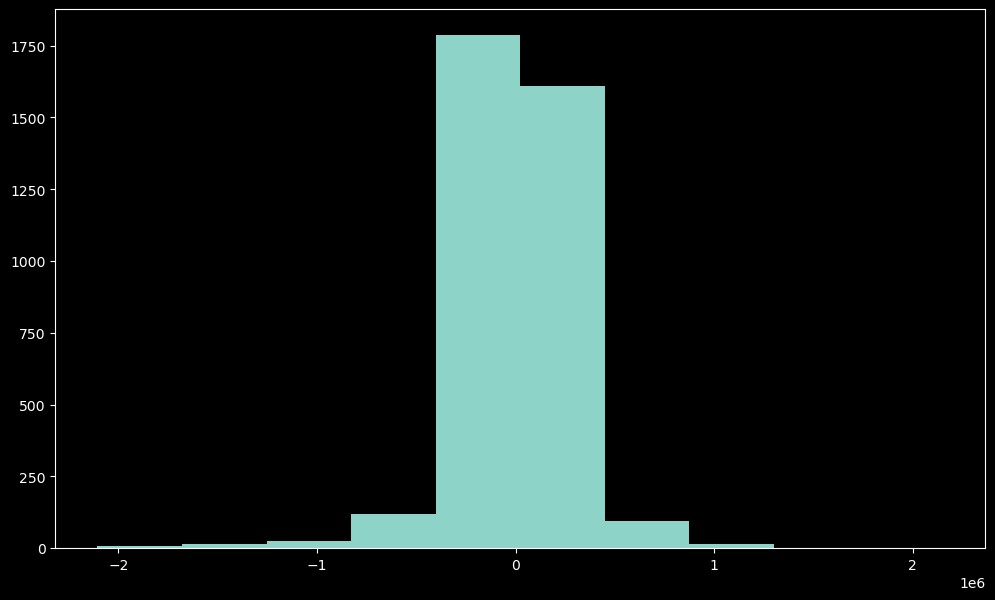

In [32]:
test['error'].hist(bins=10, grid=False, figsize=(12,7))
plt.show()

In [33]:
test['error'].mean()

-1710.3588283460588

В среднем модель занижает.

In [34]:
#абсолютная ошибка
test['error_abs'] = abs(test['error'])

# топ 10 жестких ошибок модели
test.sort_values(by='error_abs', ascending=False).head(10)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,Price_pred,error,error_abs
4847,Malvern,2/5 Moorakyne Av,4,h,1395000.0,S,Marshall,27/11/2016,7.4,3144.0,NaN,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,4675.0,3046,3.546933e+06,2.151933e+06,2.151933e+06
8171,Toorak,37 Tintern Av,3,h,5000000.0,VB,Kay,28/05/2016,4.6,3142.0,NaN,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,7217.0,4652,2.894636e+06,-2.105364e+06,2.105364e+06
5691,Northcote,167 Clarke St,5,h,4300000.0,SP,McGrath,24/09/2016,5.5,3070.0,4.0,4.0,3.0,569.0,NaN,1910.0,Darebin City Council,-37.77630,144.99640,Northern Metropolitan,11364.0,32596,2.220999e+06,-2.079001e+06,2.079001e+06
18131,Malvern,7 Northbrook Av,4,h,860000.0,SP,Abercromby's,26/08/2017,5.9,3144.0,4.0,2.0,3.0,633.0,NaN,NaN,Stonnington City Council,-37.85612,145.03273,Southern Metropolitan,4675.0,28771,2.861822e+06,2.001822e+06,2.001822e+06
772,Balwyn,1 Prowse Av,6,h,4600000.0,SP,Philip,26/07/2016,9.7,3103.0,NaN,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,5682.0,25265,2.599211e+06,-2.000789e+06,2.000789e+06
2205,Canterbury,14 Monomeath Av,5,h,5110000.0,S,Jellis,28/05/2016,9.0,3126.0,NaN,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,3265.0,1317,3.159541e+06,-1.950459e+06,1.950459e+06
2085,Camberwell,11 Sunnyside Av,3,h,3775000.0,S,Jellis,10/12/2016,7.8,3124.0,NaN,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,8920.0,31737,1.862324e+06,-1.912676e+06,1.912676e+06
10387,Parkville,21 Morrah St,4,h,3970000.0,S,Collins,13/05/2017,2.6,3052.0,4.0,3.0,1.0,289.0,NaN,NaN,Melbourne City Council,-37.79590,144.95690,Northern Metropolitan,2309.0,14881,2.105591e+06,-1.864409e+06,1.864409e+06
5441,Newport,75 The Strand,4,h,3420000.0,PI,RT,22/08/2016,8.4,3015.0,4.0,2.0,2.0,757.0,NaN,1886.0,Hobsons Bay City Council,-37.84900,144.89470,Western Metropolitan,5498.0,14667,1.640145e+06,-1.779855e+06,1.779855e+06
7089,South Melbourne,58C Napier St,3,h,770000.0,S,hockingstuart,18/03/2017,2.1,3205.0,3.0,2.0,1.0,2325.0,NaN,NaN,Port Phillip City Council,-37.83460,144.96730,Southern Metropolitan,5943.0,7907,2.443656e+06,1.673656e+06,1.673656e+06


In [35]:
# сгруппирую по цене
test['price_group'] = pd.qcut(test['Price'], 5)

In [36]:
# посмотрю на каких ценовых группах модель ошибается больше
t1 = test.groupby('price_group')[['error_abs', 'error']].agg({'count', 'mean'})
t1 = t1.droplevel(1,axis=1)
t1

,error_abs,error_abs,error,error
price_group,,,,
"(229999.999, 582500.0]",87183.623158,736,59949.857313,736
"(582500.0, 765000.0]",93707.224189,739,34099.228000,739
"(765000.0, 1005000.0]",128024.026312,732,39604.672619,732
"(1005000.0, 1410000.0]",167351.944373,734,754.842478,734
"(1410000.0, 5110000.0]",339589.887043,734,-143259.765537,734


Больше всего модель ошибается на самых дорогих объектах. Посмотрю как ошибается модель на других фичах.

In [37]:
test['Landsize_gr'] = pd.cut(test['Landsize'], [-1, 100, 500, 1000, 5000])
test['Distance_gr'] = pd.cut(test['Distance'], [-1, 10, 20, 30, 40, 100])
test['Propertycount_gr'] = pd.cut(test['Propertycount'], [-1, 5000, 10000, 15000, 20000, 30000])

In [38]:
def model_error(col):
    t1 = test.groupby(col)[['error_abs', 'error']].agg({'count', 'mean'})
    t1.columns = ['error_abs', 'for_drop', 'error', 'error_count']
    t1 = t1.drop(['for_drop'], axis=1)
    display(t1.style.background_gradient(cmap='Blues', subset=['error_abs', 'error']))

In [39]:
test.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id', 'Price_pred',
       'error', 'error_abs', 'price_group', 'Landsize_gr', 'Distance_gr',
       'Propertycount_gr'],
      dtype='object')

In [40]:
test

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,Price_pred,error,error_abs,price_group,Landsize_gr,Distance_gr,Propertycount_gr
4457,Kensington,5 Rigby La,3,t,845000.0,S,Nelson,4/03/2017,4.2,3031.0,3.0,2.0,1.0,132.0,105.0,NaN,Melbourne City Council,-37.79070,144.92470,Northern Metropolitan,5263.0,23921,8.994489e+05,54448.875177,54448.875177,"(765000.0, 1005000.0]","(100.0, 500.0]","(-1, 10]","(5000, 10000]"
15951,Epping,10/81 Rufus St,2,u,291000.0,S,HAR,9/09/2017,19.6,3076.0,2.0,1.0,1.0,161.0,NaN,NaN,Whittlesea City Council,-37.64888,145.02313,Northern Metropolitan,10926.0,29993,3.902143e+05,99214.314822,99214.314822,"(229999.999, 582500.0]","(100.0, 500.0]","(10, 20]","(10000, 15000]"
13988,Eltham,17/1336 Main Rd,4,h,762000.0,S,Jellis,12/08/2017,18.0,3095.0,4.0,2.0,2.0,573.0,180.0,1980.0,Banyule City Council,-37.70477,145.16552,Eastern Metropolitan,6990.0,18337,9.111161e+05,149116.056947,149116.056947,"(582500.0, 765000.0]","(500.0, 1000.0]","(10, 20]","(5000, 10000]"
4936,Malvern East,5/25 Clarence St,1,u,373000.0,SP,hockingstuart,24/09/2016,11.2,3145.0,1.0,1.0,1.0,0.0,38.0,1965.0,Stonnington City Council,-37.87280,145.04170,Southern Metropolitan,8801.0,2406,3.255844e+05,-47415.586681,47415.586681,"(229999.999, 582500.0]","(-1.0, 100.0]","(10, 20]","(5000, 10000]"
2896,Elsternwick,3/477 Kooyong Rd,3,t,1071000.0,S,Biggin,16/04/2016,8.5,3185.0,3.0,2.0,2.0,179.0,125.0,2000.0,Glen Eira City Council,-37.89610,145.01250,Southern Metropolitan,4898.0,19596,1.141555e+06,70554.665584,70554.665584,"(1005000.0, 1410000.0]","(100.0, 500.0]","(-1, 10]","(-1, 5000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,Heidelberg Heights,522 Waterdale Rd,2,h,526000.0,S,Barry,27/06/2016,10.5,3081.0,2.0,1.0,1.0,310.0,NaN,1994.0,Banyule City Council,-37.73890,145.04860,Eastern Metropolitan,2947.0,24146,5.291625e+05,3162.522212,3162.522212,"(229999.999, 582500.0]","(100.0, 500.0]","(10, 20]","(-1, 5000]"
2012,Burwood,1/392 Burwood Hwy,3,t,752000.0,S,Allens,17/09/2016,11.7,3125.0,4.0,2.0,2.0,217.0,NaN,1993.0,Monash City Council,-37.85220,145.13120,Southern Metropolitan,5678.0,17971,8.794792e+05,127479.193592,127479.193592,"(582500.0, 765000.0]","(100.0, 500.0]","(10, 20]","(5000, 10000]"
3509,Glen Iris,1/46 Iris Rd,3,h,1222000.0,S,Marshall,8/10/2016,9.2,3146.0,3.0,1.0,1.0,215.0,NaN,NaN,Boroondara City Council,-37.85000,145.05700,Southern Metropolitan,10412.0,27335,1.181732e+06,-40267.662980,40267.662980,"(1005000.0, 1410000.0]","(100.0, 500.0]","(-1, 10]","(10000, 15000]"
176,Alphington,10 Bennett St,4,h,1830000.0,S,Nelson,19/11/2016,6.4,3078.0,4.0,2.0,2.0,606.0,112.0,1970.0,Darebin City Council,-37.77430,145.03160,Northern Metropolitan,2211.0,14164,1.602406e+06,-227594.144656,227594.144656,"(1410000.0, 5110000.0]","(500.0, 1000.0]","(-1, 10]","(-1, 5000]"


In [41]:
cols = ['Rooms', 'Distance_gr', 'Bathroom', 'Car', 
        'Landsize_gr', 'Propertycount_gr','Type', 'Method']

In [42]:
for i in cols:
    model_error(i)

,error_abs,error,error_count
Rooms,,,
1,93918.682866,12059.500839,177
2,122779.594677,-4880.345668,1030
3,151673.954004,-10879.672572,1563
4,228196.334445,12761.940628,729
5,287807.567516,10887.289388,155
6,370133.595368,95793.734401,20
8,704724.664270,704724.664270,1


,error_abs,error,error_count
Distance_gr,,,
"(-1, 10]",189463.316151,-4122.723125,1900
"(10, 20]",140035.499369,155.546506,1554
"(20, 30]",101620.508686,7916.300431,164
"(30, 40]",89863.942129,2210.089832,49
"(40, 100]",70139.193155,-12585.212436,8


,error_abs,error,error_count
Bathroom,,,
0.000000,224321.414878,221239.601898,4
1.000000,120596.773656,1552.667247,1659
2.000000,171786.748507,-4072.621480,1076
3.000000,255237.070927,63237.664776,197
4.000000,601477.272289,-62835.325756,24
5.000000,408285.893835,94273.556030,8
6.000000,285007.960986,-285007.960986,1


,error_abs,error,error_count
Car,,,
0.000000,149479.186807,1465.221607,201
1.000000,124513.296297,-3227.555002,1237
2.000000,169121.038353,8991.431869,1212
3.000000,203866.890252,8172.084038,160
4.000000,186854.896272,-1548.103523,108
5.000000,245914.026926,172736.102868,14
6.000000,257396.211840,-82941.268913,15
7.000000,26673.572870,26673.572870,1
8.000000,387809.870693,-287198.165727,2


,error_abs,error,error_count
Landsize_gr,,,
"(-1, 100]",109139.643204,18634.361152,475
"(100, 500]",150025.373023,-20273.026843,1022
"(500, 1000]",163535.794419,17032.528658,1092
"(1000, 5000]",250658.080247,-3377.994582,134


,error_abs,error,error_count
Propertycount_gr,,,
"(-1, 5000]",161064.781971,-7033.428828,1189
"(5000, 10000]",169922.750657,-5295.755741,1541
"(10000, 15000]",163824.736922,15328.451616,753
"(15000, 20000]",144206.822549,259.936497,85
"(20000, 30000]",95804.537342,-12397.017652,107


,error_abs,error,error_count
Type,,,
h,189522.905409,-1102.830754,2400
t,126329.361088,-17929.252334,397
u,107309.735200,3962.572088,878


,error_abs,error,error_count
Method,,,
PI,173576.781690,14928.538688,427
S,161901.788149,-6615.321964,2423
SA,209723.072585,-22269.043709,24
SP,141402.246146,-9435.756072,464
VB,184499.591753,24574.238191,337


- rooms; Самая большая ошибка на единичном объекте с очень большой ценой. В целом, при достаточно большом кол-ве объектом модель занижает стоимость по данной фиче;
- Distance_gr Здесь максимальная абсолютная ошибка по объектам с неизвестным расстоянием от центра, либо находящихся в близости к центру; Модель склонна занижать по данной фиче;
- Bathroom; Самые большие ошибки по объектам с 4 и более ванными, но таких мало. При большом кол-ве объектов ситуация такая: на объектах с 1 ванной модель завышает, с 2-мя занижает;
- Car; Ситуация схожа с фичей Bathroom;
- Landsize_gr; Чем больше земельный участок, тем сильнее модель ошибается. Отклонение в данном случае оценивать сложно, нужна более детальная группировка;
- Propertycount_gr; Здесь интересная ситуация. Чем больше конкурентных объектов вокруг, тем точнее модель делает предикт. При этом модель занижает стоимость как на сильно маленьких группах, так и на самой большой; Возможно данная ситуация связана с тем, что в самой конкурентной группе достаточно мало объектов;
- Type; Самая большая абсолютная ошибка по частным домам (занижает), самая маленькая по дуплексам (завышает);
- Method; SA - самая большая ошибка, модель занижает. SP - самая маленькая ошибка, модель так же занижает.

Сделав вывод, можно отметить, что при достаточно большом количестве объектов в группе, в среднем модель склонна к занижению.

#### Посмотрю важность фичей по мнению кэтбуста

In [43]:
# парраметр prettified выводит отсортированный датафрейм по важности фичей
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Rooms,15.262202
1,Regionname,14.702392
2,Distance,13.223323
3,Type,11.815650
4,CouncilArea,7.732388
5,Landsize,6.774650
6,Bathroom,4.354786
7,BuildingArea,3.774373
8,Suburb,3.749852
9,SellerG,3.416480


Получается, что территориальные факторы и тип недвижимости очень сильно лидируют. Меньше всего влияние оказывают такие фичи, как: кол-во парковочных мест, метод продажи, год постройки.

#### Посмотрю вклад каждой фичи в предсказание модели

In [44]:
# пользуюсь библиотекой shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
pd.DataFrame(shap_values, columns=X).head()

,Suburb,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname
0,-16959.513870,37403.830054,-127410.630618,15474.692817,-7147.312022,21887.361381,177896.705879,-4607.014837,53978.404032,-22662.325508,-105147.485183,-39280.149107,4054.292844,-18082.812200,-14518.407901,-23169.707476,-85255.192504
1,-54899.511695,-67113.293683,-126846.222401,16217.540862,-27349.466550,16718.701280,-98475.240924,-3453.884138,-26327.623429,-19972.333516,-66370.146960,-23959.247652,3328.136954,-60867.255484,-79275.123957,8145.278362,-52280.131644
2,7363.418916,109603.488217,39402.452388,20824.930425,31195.061536,29132.632060,-194895.226704,2669.000737,34067.010517,12787.168698,5456.951626,19345.358032,-50331.747775,-23857.203380,-109508.920447,-30799.779341,-44332.677954
3,9300.583198,-281508.145325,-219674.111959,-5420.950108,-3192.775269,-25171.644951,-28029.034143,3789.101290,-41494.027101,-27010.760377,-88581.183232,-44531.534804,-37712.299483,-1109.937288,26225.615360,-20723.626143,57435.004255
4,22037.566863,29847.108914,-104705.992860,9883.945897,-6974.073461,-34433.909248,32928.654903,28599.193205,51105.373540,15302.338814,-81991.959859,-23998.196013,-55537.180774,29916.250998,28177.638723,14736.422334,133667.344213


In [45]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[0, :], test[X].iloc[0,:])
# в кратце: график показывает в какую сторону и насколько каждая фича двигала предикт относительно беизлайна по 1 строке
# датафрейма

В целом, согласно моему анализу, модель занижает стоимость.По мнению шапа, модель так же занижает. Но это только анализ 1-й строки.
ННужно посмотреть на общую картину.

In [46]:
# сохраню в фичу называния столбцов для шапа, чтобы не дублились названия столбцов
shap_columns = [i + '_shap' for i in X]

#делаю датафрейм с данными шапа
df_shap = pd.DataFrame(shap_values, columns=shap_columns)

#чтобы не было некорректного соединения из-за различия индексов
test_machine = test.reset_index(drop=True)

# соединяю по горизонту данные трейн и шап
test_shap = pd.concat([test, df_shap], axis=1)
test_shap.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,Price_pred,error,error_abs,price_group,Landsize_gr,Distance_gr,Propertycount_gr,Suburb_shap,Rooms_shap,Type_shap,Method_shap,SellerG_shap,Date_shap,Distance_shap,Postcode_shap,Bathroom_shap,Car_shap,Landsize_shap,BuildingArea_shap,YearBuilt_shap,CouncilArea_shap,Lattitude_shap,Longtitude_shap,Regionname_shap
4457,Kensington,5 Rigby La,3.0,t,845000.0,S,Nelson,4/03/2017,4.2,3031.0,3.0,2.0,1.0,132.0,105.0,NaN,Melbourne City Council,-37.79070,144.92470,Northern Metropolitan,5263.0,23921.0,8.994489e+05,54448.875177,54448.875177,"(765000.0, 1005000.0]","(100, 500]","(-1, 10]","(5000, 10000]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15951,Epping,10/81 Rufus St,2.0,u,291000.0,S,HAR,9/09/2017,19.6,3076.0,2.0,1.0,1.0,161.0,NaN,NaN,Whittlesea City Council,-37.64888,145.02313,Northern Metropolitan,10926.0,29993.0,3.902143e+05,99214.314822,99214.314822,"(229999.999, 582500.0]","(100, 500]","(10, 20]","(10000, 15000]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13988,Eltham,17/1336 Main Rd,4.0,h,762000.0,S,Jellis,12/08/2017,18.0,3095.0,4.0,2.0,2.0,573.0,180.0,1980.0,Banyule City Council,-37.70477,145.16552,Eastern Metropolitan,6990.0,18337.0,9.111161e+05,149116.056947,149116.056947,"(582500.0, 765000.0]","(500, 1000]","(10, 20]","(5000, 10000]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4936,Malvern East,5/25 Clarence St,1.0,u,373000.0,SP,hockingstuart,24/09/2016,11.2,3145.0,1.0,1.0,1.0,0.0,38.0,1965.0,Stonnington City Council,-37.87280,145.04170,Southern Metropolitan,8801.0,2406.0,3.255844e+05,-47415.586681,47415.586681,"(229999.999, 582500.0]","(-1, 100]","(10, 20]","(5000, 10000]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2896,Elsternwick,3/477 Kooyong Rd,3.0,t,1071000.0,S,Biggin,16/04/2016,8.5,3185.0,3.0,2.0,2.0,179.0,125.0,2000.0,Glen Eira City Council,-37.89610,145.01250,Southern Metropolitan,4898.0,19596.0,1.141555e+06,70554.665584,70554.665584,"(1005000.0, 1410000.0]","(100, 500]","(-1, 10]","(-1, 5000]",24587.842776,249355.490204,81839.80027,-29455.114479,6796.871091,17318.199467,223874.362776,7799.952966,218640.692769,6620.844055,72204.891651,4765.62142,-56976.244716,46956.395238,50846.879215,-124738.581635,-183955.598559


In [47]:
test_shap_without_nan = test_shap.dropna()

In [48]:
shap.initjs()
(
    shap.plots.force(
        explainer.expected_value, test_shap_without_nan[shap_columns].head(1000).values, 
                     test_shap_without_nan[X].head(1000)
                    )
)

Посмотре 1000 строк, т.к. прибольшем кол-ве, очень долого грузит. График динамичный, можно смотреть отдельно по каждой фиче. Но если судить по общей картине, модель занижает стоимость, хотя есть "скачки" с объектоами, по которым модель резко завышает. 

Дополнительно посмотрю графики зависимостей переменных по мнению шапа и на этом закончу анализ.

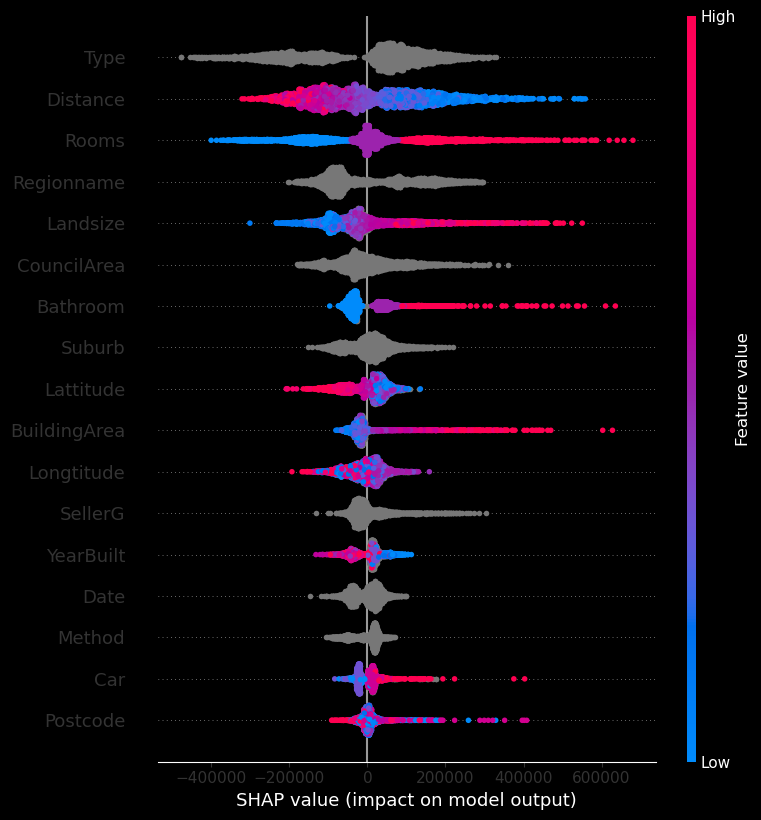

In [49]:
shap.summary_plot(shap_values, test[X])
# легко читаем - показывает насколько идет завшение или занижение 
# серым - категориальные фичи. По ним нельзя построить, соответственно оценивать нельзя